# LLM-power Clickbait Detector - Part 2

In this part, we consider fine-tuning a small model like Flan-T5-Base for a Clickbait classifier. First we have to import necessary libraries

In [1]:
# import required libraries
import openai
import os
import IPython
import pandas as pd
import numpy as np
import comet_llm
import comet_ml
import pickle
import json
import torch

from transformers import AutoTokenizer
from datasets import load_dataset
import evaluate
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
import transformers
transformers.set_seed(35)
from datasets import Features, Value, Dataset, DatasetDict
from sklearn.model_selection import train_test_split


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# API configuration
openai.api_key = "YOUR_OPEN_API_KEY"

COMET_API_KEY = "YOUR_COMET_API"
COMET_WORKSPACE = "YOUR_COMET_WORKSPACE"

/Users/Tolu/llmops/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Import Data

In [2]:
# read data
import pandas as pd
df = pd.read_csv('data_folder/clickbait_data.csv')
df.head()

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1


### Data Preparation

In [3]:
# Split dataset
test_size = 0.2
train_data, val_data = train_test_split(df, stratify=df.clickbait, test_size=test_size, random_state=123)
val_data, test_data = train_test_split(val_data, stratify=val_data.clickbait, test_size=test_size, random_state=101)

In [48]:
# Label to index   
class_to_index= {'non-clickbait': 0, 'clickbait': 1}
index_to_class = {v:k for k, v in class_to_index.items()}

def index_to_class_decode(indices, index_to_class):
    return [index_to_class[index] for index in indices]

def class_to_index_decode(classes, class_to_index):
    return [class_to_index[index] for index in classes]

In [5]:
#train_data.headline = train_data.headline.apply(clean_text)
#val_data.headline = val_data.headline.apply(clean_text)

### Data Sampling

In [6]:
sample = True

if sample == True:
    final_ds = DatasetDict({
        "train": Dataset.from_pandas(train_data.sample(200)),
        "validation": Dataset.from_pandas(val_data.sample(50)),
        "test": Dataset.from_pandas(test_data.sample(25))
        
    })
else:
    final_ds = DatasetDict({
        "train": Dataset.from_pandas(train_data),
        "validation": Dataset.from_pandas(val_data),
        "test": Dataset.from_pandas(test_data)
    })

### Base Model using OpenAI chatGPT

To evaluate the performance of the finetuned model, we need to compare the preformace with that of a base model. In our case, the base model is OpenAI's `gpt-3.5-turbo` model with zero-shot learning. Zero-shot learning  technique provides the model with the infomation that tells it what task to perform but with no examples. To design the instruction that tell the model what task to perform, we design a a set of instructions know as prompts. In general, Prompts are instructions and context passed to a language model to achieve a desired task. The task for this project is to classify article headlines as clickbait or non-clickbait using LLM.

In [36]:
# prompt design 
prompt_prefix = """
Your task is to classify the headline of an article as Clickbait or Non-clickbait. A clickbait is a text designed to attract attention and to entice users to read, view, or listen to the linked piece of content, being typically deceptive, sensationalized, or otherwise misleading. 
"""
prompt_suffix = """headline: {Input} \nTags: """

The `get_completion` function below enables us to get response from the `gpt-3.5-turbo` model

In [8]:
# completion function
model = "gpt-3.5-turbo"
def get_completion(messages, model = "gpt-3.5-turbo", temperature=0, max_tokens=300):
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens,
    )
    return response.choices[0].message["content"]

In [37]:
# zero shot prompt template
zero_shot_template = prompt_prefix + prompt_suffix
zero_shot_template 

'\nYour task is to classify the headline of an article as Clickbait or Non-clickbait. A clickbait is a text designed to attract attention and to entice users to read, view, or listen to the linked piece of content, being typically deceptive, sensationalized, or otherwise misleading. \nheadline: {Input} \nTags: '

In [10]:
## testing zero-shot
message = [
    {
        "role": "system",
        "content": zero_shot_template.format(Input=df['headline'][21000])
    }
]

response = get_completion(message)
print(response)

['Non-clickbait']


### Finetuning Model
For the model we will be finetuning, we will use google's `flan-t5-base` model. First we have to tokenize the data

### Tokenize Dataset

In [11]:
# model checkpoint
model_checkpoint = "google/flan-t5-base"

# We'll create a tokenizer from model checkpoint
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False, legacy = False)

# We'll need padding to have same length sequences in a batch - needed for flan-t5
tokenizer.pad_token = tokenizer.eos_token

# prefix
prefix_instruction = prompt_prefix 

# Define a tokenization function that first concatenates text and target
def tokenize_function(example):
    merged = prefix_instruction + "\n\n" + "Text: " + example["headline"].strip("\n\n###\n\n") + "\n\n" + "tags:" + str(example["clickbait"])
    batch = tokenizer(merged, padding='max_length', truncation=True)
    batch["labels"] = batch["input_ids"].copy()
    return batch

# Apply it on our dataset, and remove the text columns
tokenized_datasets = final_ds.map(tokenize_function, remove_columns=["headline", "clickbait"])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

### Model training + logging project to Comet
Once the datasets have been tokenized, it is time to finetune the model. We are using the hugging face (HF) Trainer to simplify the finetuning code. In the code below, it's also important to initialize a Comet project which allows tracking the experimental results to Comet. We can also set the COMET_LOG_ASSETS to True to store all model assets and artifacts to Comet.

In [13]:
# initialize comet_ml
comet_ml.init(project_name="clickbait-detector-flan-t5", workspace = COMET_WORKSPACE)

# training an autoregressive language model from a pretrained checkpoint
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint).to(device)


# set this to log HF results and assets to Comet
os.environ["COMET_LOG_ASSETS"] = "True"

# HF Trainer
model_name = model_checkpoint.split("/")[-1]
training_args = Seq2SeqTrainingArguments(
    num_train_epochs=1,
    output_dir="./results",
    overwrite_output_dir=True,
    logging_steps=1,
    evaluation_strategy = "epoch",
    learning_rate=1e-4,
    weight_decay=0.01,
    save_total_limit=5,
    save_steps=7,
    auto_find_batch_size=True,
    use_cpu = True,    
)

# instantiate HF Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
)

# run trainer
trainer.train()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/Users/Tolu/llmops/venv' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/projects-space/clickbait-detector-flan-t5/b21d5b82214e478186a04a0d3f3cdfa9



Epoch,Training Loss,Validation Loss
1,0.004100,0.000811


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/projects-space/clickbait-detector-flan-t5/b21d5b82214e478186a04a0d3f3cdfa9
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch [27]                     : (0.04, 1.0)
COMET INFO:     eval/loss                      : 0.0008105471497401595
COMET INFO:     eval/runtime                   : 25.1905
COMET INFO:     eval/samples_per_second        : 1.985
COMET INFO:     eval/steps_per_second          : 0.278
COMET INFO:     eval_loss                      : 0.0008105471497401595
COMET INFO:     eval_runtime                   : 25.1905
COMET INFO:     eval_samples_per_second        : 1.985
COMET INFO:     eval_steps_per_second

TrainOutput(global_step=25, training_loss=0.1696572124399245, metrics={'train_runtime': 1082.6315, 'train_samples_per_second': 0.185, 'train_steps_per_second': 0.023, 'total_flos': 136951470489600.0, 'train_loss': 0.1696572124399245, 'epoch': 1.0})

### Save Finetuned Model

Now we save the model locally

In [14]:
# save the model
trainer.save_model("./results")

### Register Model

We will register the model to comet

In [15]:
# set existing experiment
from comet_ml import ExistingExperiment

experiment = ExistingExperiment(api_key=COMET_API_KEY, previous_experiment="b21d5b82214e478186a04a0d3f3cdfa9")
experiment.log_model("Clickbait-Detector-Flan-T5-Base", "./results/checkpoint-7")
experiment.register_model("Clickbait-Detector-Flan-T5-Base")

experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/Users/Tolu/llmops/venv' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/projects-space/clickbait-detector-flan-t5/b21d5b82214e478186a04a0d3f3cdfa9

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/projects-space/clickbait-detector-flan-t5/b21d5b82214e478186a04a0d3f3cdfa9
COMET INFO:   Uploads:
COMET INFO:     model-element : 12 (2.77 GB)
COMET 

### Deploy the Model

To deploy the model, first we have to dowload the model and tokenizer we are trying to use from Comet. Then, use Huggingface's Transformers library to load the pretrained model and tokenizer.

In [16]:
from comet_ml import API

api = API(api_key=COMET_API_KEY)

# model name
model_name = "clickbait-detector-flan-t5-base"

#get the Model object
model = api.get_model(workspace=COMET_WORKSPACE, model_name=model_name)

# Download a Registry Model:
model.download("1.0.0", "./deploy", expand=True)

COMET INFO: Remote Model 'projects-space/clickbait-detector-flan-t5-base:1.0.0' download has been started asynchronously.
COMET INFO: Still downloading 12 file(s), remaining 2.77 GB/2.77 GB
COMET INFO: Still downloading 2 file(s), remaining 2.34 GB/2.77 GB, Throughput 28.74 MB/s, ETA ~84s
COMET INFO: Still downloading 2 file(s), remaining 1.85 GB/2.77 GB, Throughput 33.45 MB/s, ETA ~57s
COMET INFO: Still downloading 2 file(s), remaining 1.38 GB/2.77 GB, Throughput 31.80 MB/s, ETA ~45s
COMET INFO: Still downloading 2 file(s), remaining 931.55 MB/2.77 GB, Throughput 32.08 MB/s, ETA ~30s
COMET INFO: Still downloading 1 file(s), remaining 689.09 MB/2.77 GB, Throughput 16.08 MB/s, ETA ~43s
COMET INFO: Still downloading 1 file(s), remaining 449.09 MB/2.77 GB, Throughput 15.91 MB/s, ETA ~29s
COMET INFO: Still downloading 1 file(s), remaining 214.09 MB/2.77 GB, Throughput 15.57 MB/s, ETA ~14s
COMET INFO: Remote Model 'projects-space/clickbait-detector-flan-t5-base:1.0.0' has been successfully 

In [17]:
model = AutoModelForSeq2SeqLM.from_pretrained("./deploy/checkpoint-7")
tokenizer = AutoTokenizer.from_pretrained("./deploy/checkpoint-7/")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Evaluate Finetuned Clickbait Classifier, Logging Prompt + Results to Comet

Evaluate different models and prompting techniques and log results when prompting the fine-tuned model. We will aslo log results with few-shot and zero-shot prompting using gpt-3.5-turbo. This way it will be possible to compare the finetuned model with other high-performing models.

### Evaluation - Confusion Matrix

We prepare a confusion matrix to better understand the performance of OpenAI's `gpt-3.5-turbo` base model with zero shot learning and the finetuned `flan-t5` model. The `get_predictions` is helper function to obtain the final predictions from the OpenAI model given a prompt template (e.g., zero-shot or few-shot) and the provided input data. 

In [31]:
def get_predictions(prompt_template, inputs):

    responses = []

    for i in range(len(inputs)):
        messages = messages = [
            {
                "role": "system",
                "content": prompt_template.format(Input=inputs[i])
            }
        ]
        response = get_completion(messages)
        responses.append(response)

    return responses

In [70]:
# finetuned model prompt prefix
prefix = prefix_instruction + "\n\n" + "Text:"

# take some test data samples as input to our models
test_data_sample = test_data.sample(50,replace=False, ignore_index=True)

# prepare prompts 
prompts = [{"headline": row.headline.strip("\n\n###\n\n"), "tags": str(row.clickbait)} for index, row in test_data_sample.iterrows()]

# prepare zero-shot and few-shot predictions
articles = [prompts[i]["headline"] for i in range(len(prompts))]
expected_tags = test_data_sample['clickbait'].to_list()

# zero shot predictions
zero_shot_predictions = get_predictions(zero_shot_template, test_data_sample.headline)
zero_shot_predictions = [x.lower() for x in zero_shot_predictions]

# finetuned model predictions
finetuned_predictions = []
for i in range(len(prompts)):
    
    # finetuned model outputs
    input_ids = tokenizer.encode(prefix + prompts[i]["headline"] + "\n\n" + " tag:", return_tensors="pt")
    output = model.generate(input_ids, do_sample=True, max_new_tokens=300, temperature=1.0)
    output_text = tokenizer.decode(output[0], skip_special_tokens=True).strip("<pad>").strip(" ")

    finetuned_predictions.append(output_text.lower())

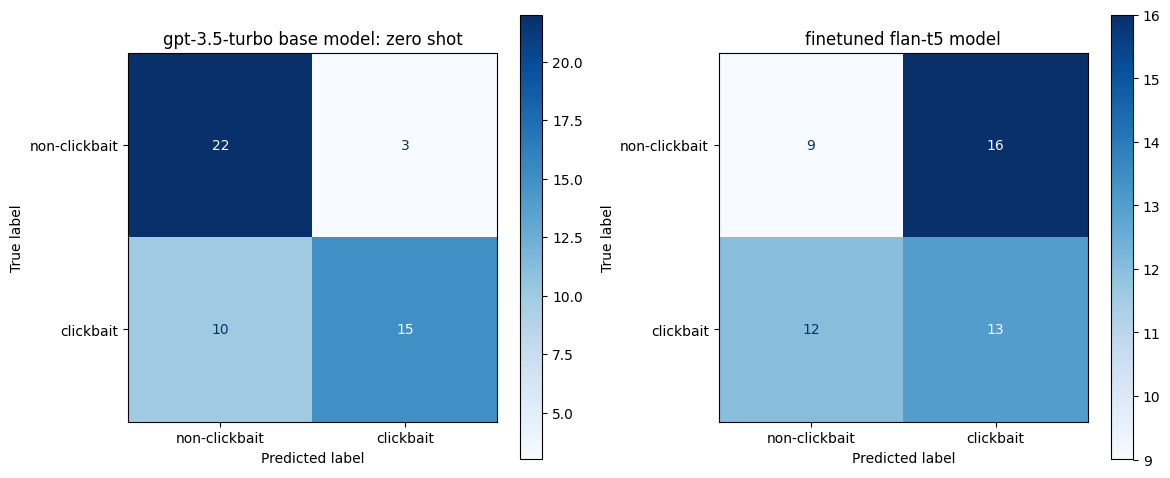

In [96]:
### Plot Confusion matrix 

from sklearn  import metrics
import seaborn as sns
import matplotlib.pyplot as plt

zero_shot_predictions_int = pd.Series(zero_shot_predictions).map(class_to_index)
finetuned_predictions_int = pd.Series(finetuned_predictions).map(class_to_index)
expected_tags_int = pd.Series(expected_tags)

# create subplots
f, ax = plt.subplots(1, 2, figsize=(12,5))

ax[0].set_title("gpt-3.5-turbo base model: zero shot")
ax[1].set_title("finetuned flan-t5 model")

metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(expected_tags_int, zero_shot_predictions_int), 
    display_labels=['non-clickbait', 'clickbait']).plot(ax=ax[0], cmap='Blues',)

metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(expected_tags_int, finetuned_predictions_int), 
    display_labels=['non-clickbait', 'clickbait']).plot(ax=ax[1],cmap='Blues',)


plt.tight_layout()  
plt.show()


### Logging Confusion Matrix to Comet

The code below saves the confusion matrice to the selected Comet experiment. You can obtained the experiment key from Comet's experiment dashboard.

In [105]:
from comet_ml import ExistingExperiment

experiment = ExistingExperiment(api_key=COMET_API_KEY, previous_experiment="b21d5b82214e478186a04a0d3f3cdfa9")
experiment.log_confusion_matrix(expected_tags_int, zero_shot_predictions_int,file_name="confusion-matrix-gpt3.json",title="gpt-3.5-turbo base model: zero shot",overwrite = True, labels=list(index_to_class.values()))
experiment.log_confusion_matrix(expected_tags_int, finetuned_predictions_int,overwrite = True,file_name="confusion-matrix-flant5.json", title="finetuned flan-t5 model", labels=list(index_to_class.values()))

experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/Users/Tolu/llmops/venv' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/projects-space/clickbait-detector-flan-t5/b21d5b82214e478186a04a0d3f3cdfa9

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/projects-space/clickbait-detector-flan-t5/b21d5b82214e478186a04a0d3f3cdfa9
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix : 1
COMET INFO: 
C

### Logging Prompts to Comet

In [43]:
# for comet logging
comet_llm.init(project="clickbait-detector-flan-t5-prompts", workspace = COMET_WORKSPACE)

for i in range(len(prompts)):      
    # log finetuned model prompts
    comet_llm.log_prompt(
        prompt = prefix + prompts[i]["headline"],
        tags = ["flan-t5-base", "fine-tuned" ],
        metadata = {
            "article": prompts[i]["headline"],
            "model_name": "flan-t5-base",
            "temperature": 1.0,
            "expected_output": expected_tags[i],
        },
        output = finetuned_predictions[i]
    )
    
    # log zero-shot prompts
    comet_llm.log_prompt(
        prompt = zero_shot_template.format(Input=prompts[i]["headline"]),
        tags = ["gpt-3.5-turbo", "zero-shot" ],
        metadata = {
            "article": prompts[i]["headline"],
            "model_name": "zero-shot",
            "expected_output": expected_tags[i],
        },
        output = zero_shot_predictions[i]
    )